<a href="https://colab.research.google.com/github/vgorbikov/mldlvsu_labs/blob/main/Lab_2_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №2
"Изучение базовых техник анализа и предобработки табличных данных. Особенности построения архитектуры многослойного персептрона в контексте задачи классификации"

**Цель работы** — научиться эффективно обрабатывать и анализировать реальные табличные данные, выявлять ключевые особенности, которые влияют на результаты моделей машинного обучения. Освоить процесс построения многослойного персептрона и его применения в задачах классификации, исследовать, как различные архитектурные решения и техники могут повлиять на точность и производительность модели.

## Задание


1. Скачайте набор данных вашего варианта и осуществите разведочный
анализ и предобработку ваших данных, следуя шагам из презентации
«Разведочный анализ данных».
2. Постройте собственную архитектуру многослойного персептрона и
осуществите обучение вашей модели для решения вашей задачи
классификации.
3. Проведите тестирование модели на тестовом наборе данных и оцените
её точность. Оптимизируйте точность, экспериментируя с подбором
следующих гиперпараметров (зафиксируйте результаты базовой и
улучшенной модели):
- количество слоёв в нейронной сети;
- количество нейронов в каждом слое;
- вид нелинейной функции активации ;
- оптимизатор и скорость обучения оптимизатора;
- размер мини-пакета;
- попробуйте использовать расписание скорости обучения Learning
Rate Schedule, например ReduceLROnPlateau;
- попробуйте использовать слои Dropout для предотвращения
переобучения;
- попробуйте использовать слои BatchNormalization для ускорения
обучения и предотвращения переобучения.
4. При работе с несбалансированными классами примените техники для
улучшения качества классификации редких классов:
- использование весов классов в функции ошибки;
- oversampling редкого класса или undersampling доминирующего
класса;
5. Осуществите сравнительный анализ точности (по Accuracy и F1-Score)
вашей
модели многослойного персептрона и классических
классификаторов машинного обучения из библиотеки sklearn
(минимально 3 любых классификатора, например, LogisticRegression,
KNeighborsClassifier, RandomForestClassifier).

## Вариант №9

Предсказание того, покинет ли клиент банк или останется клиентом,
используя информацию о его поведении и характеристиках.
https://www.kaggle.com/datasets/shrutimechlearn/churn-modelling/data

## Решение

### 1. Скачайте набор данных вашего варианта и осуществите разведочный анализ и предобработку ваших данных, следуя шагам из презентации «Разведочный анализ данных».

#### Ознакомление с данными

In [1]:
! pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 12.2 MB/s eta 0:00:00


In [32]:
import os

import kagglehub
import pandas
import seaborn as sbn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from torch import nn
from torch import tensor
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import BinaryAccuracy
import torch
import numpy as np

In [4]:
# получаем датасет с kaggle
path = kagglehub.dataset_download("shrutimechlearn/churn-modelling")
path = path + f'/{os.listdir(path)[0]}'
# грузим в pandas
df = pandas.read_csv(path)

Using Colab cache for faster access to the 'churn-modelling' dataset.


In [5]:
# предпросмотр данных
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
# общая информация о заполненности атрибутов данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [8]:
# статистические характеристики количественных атрибутов
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [9]:
# подсчёт количества уникальных значений по атрибутам данных
df.nunique()

,0
RowNumber,10000
CustomerId,10000
Surname,2932
CreditScore,460
Geography,3
Gender,2
Age,70
Tenure,11
Balance,6382
NumOfProducts,4


По итогу ознакомления с данными, можем сделать следующие **выводы**:
- У нас есть следующие **категориальные признаки**:
  - Geography (необходима кодировка)
  - Gender (необходима кодировка)
  - IsActiveMember
  - HasCrCard
- Есть атрибуты, не влияющие на решение задачи классификации, которые **можно отбросить**:
  - Surname
  - CustomerId
  - RowNumber
- Нет атрибутов с пропусками в данных (null-значения)

#### Предварительная обработка данных

In [10]:
# отбросим лишние атрибуты
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [11]:
# кодируем категориальные признаки one-hot методом
df = pandas.get_dummies(df, columns=['Geography', 'Gender'], dtype=float)

In [12]:
def boxplot_set(df: pandas.DataFrame, columns: list[str]):
  '''
  Функция для отрисовки ящика с усами по всем необходимым столбцам
  '''
  cols = df[columns].columns
  l = len(cols)

  for s, i in [(cols[i], i) for i in range(l)]:
    plt.subplots_adjust(wspace=1)
    plt.subplot(1, 3, i%3+ 1)
    sbn.boxplot(df[s])
    if ((i+1)%3 == 0) and (i != 0):
      plt.show()

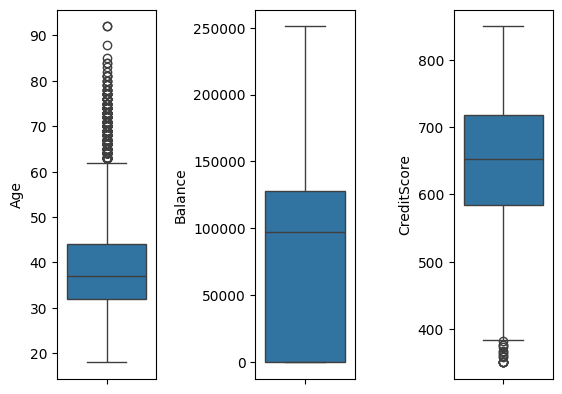

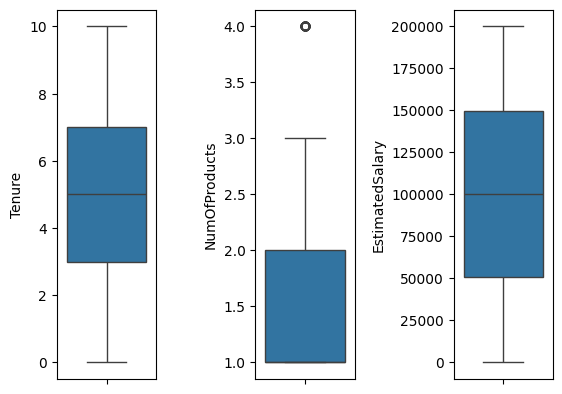

In [13]:
# изучаем данные на распределение и выбросы
cols = ['Age', 'Balance', 'CreditScore', 'Tenure', 'NumOfProducts', 'EstimatedSalary']
boxplot_set(df, cols)

Некоторые признаки имеют неравномерное распределение и выбросы, однако, **удалять выбросы мы не будем**. Исходя из бизнес-смысла данных признаков, есть предположение о важности экстремальных значений для решения задачи.

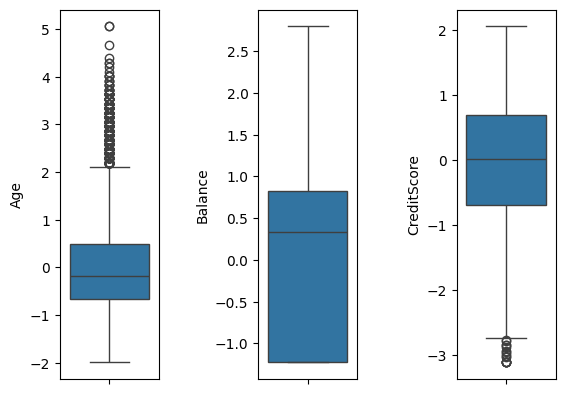

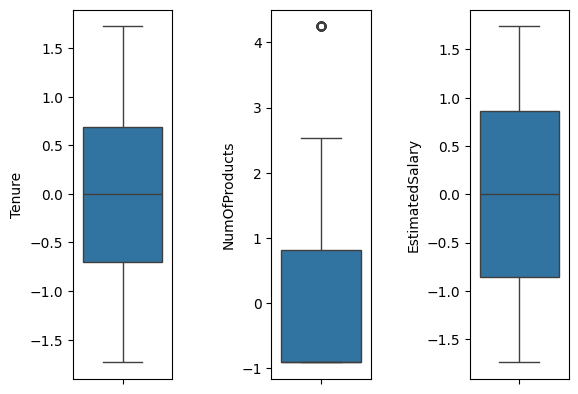

In [14]:
# стандартизация количественных признаков
q_cols = ['Age', 'Balance', 'CreditScore', 'EstimatedSalary', 'Tenure', 'NumOfProducts']
scal = StandardScaler()
df[q_cols] = scal.fit_transform(df[q_cols])

boxplot_set(df, cols)

In [15]:
# делим датасет на признаки и целевые значения, тренировочную и тестовую выборки
X = tensor(df.loc[:, df.columns != 'Exited'].values, dtype=torch.float64)
Y = tensor(np.expand_dims(df['Exited'].values, 1), dtype=torch.float64)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, stratify=Y_test)

### 2. Постройте собственную архитектуру многослойного персептрона и осуществите обучение вашей модели для решения вашей задачи классификации.



In [75]:
class SModel(nn.Module):
  def __init__(self, inp_size: int, out_size: int, hidden_sizes: list, act_f, use_dropout: bool = False) -> None:
    super(SModel, self).__init__()

    # дополняем последовательность кратностей связей значениями входного и выходного слоя
    hidden_sizes.insert(0, inp_size)
    hidden_sizes.append(out_size)

    self.activation = act_f
    self._out_activation = nn.Sigmoid()
    self.use_dropout = use_dropout

    # динамическая инициализация полносвязных линейных слоёв
    for i in range(1, len(hidden_sizes)):
      self.__setattr__(f'l_{i}', nn.Linear(hidden_sizes[i-1], hidden_sizes[i], dtype=torch.float64))

    # динамическая инициализация dropuot слоёв, если используются
    if self.use_dropout:
      for j in range(1, len(hidden_sizes)-1):
        self.__setattr__(f'drp_{j}', nn.Dropout(p=0.2))


  def forward(self, x):
    last_act = x
    linears = [m[1] for m in self._modules.items() if m[0].startswith('l_')]
    dropouts = [m[1] for m in self._modules.items() if m[0].startswith('drp_')]
    linears_count = len(linears)

    for l_num in range(linears_count):
      if l_num == linears_count-1:
        last_act = self._out_activation(linears[l_num](last_act))
      else:
        last_act = self.activation(linears[l_num](last_act))
      if self.use_dropout and (l_num != linears_count-1):
        last_act = dropouts[l_num](last_act)
    return last_act


In [80]:
def train_model(model: nn.Module, dloader: DataLoader, x_val: tensor, y_val: tensor, epoch: int = 10000, lr: float = 0.01, stop_acc: float = 0.9):
  loss_f = nn.BCELoss()
  acc_f = BinaryAccuracy(threshold=0.5)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  stats = {'loss_train': [], 'acc_train': [], 'acc_val': [], 'loss_val': []}

  for epoch_no in range(epoch):
    epoch_tloss = []
    epoch_vloss = []
    epoch_tacc = []
    epoch_vacc = []
    for idx, (x, y) in enumerate(dloader):
      model.train()
      outs = model(x)
      loss = loss_f(outs, y)
      accuracy = acc_f(outs, y)

      epoch_tloss.append(loss.item())
      epoch_tacc.append(accuracy)
      model.eval()
      val_outs = model(x_val)
      epoch_vacc.append(acc_f(val_outs, y_val))
      epoch_vloss.append(loss_f(val_outs, y_val).item())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    stats['loss_train'].append(np.average(epoch_tloss))
    stats['acc_train'].append(np.average(epoch_tacc))
    val_outs = model(x_val)
    stats['acc_val'].append(np.average(epoch_vacc))
    stats['loss_val'].append(np.average(epoch_vloss))

    if epoch_no%3 == 0 or epoch_no == epoch-1:
      print(f'Epoch: {epoch_no}; Loss: {stats["loss_train"][-1]}; Acc: {stats["acc_train"][-1]}; Val_loss: {stats["loss_val"][-1]}; Val_acc: {stats["acc_val"][-1]}')

    if stats["acc_train"][-1] >= stop_acc:
      model.eval()
      break

  return model, stats

In [58]:
inp_size = X_train.shape[1]

In [65]:
# инициализируем DataLoader для обучающего датасета
dset = TensorDataset(X_train, Y_train)
dloader = DataLoader(
    dataset=dset,
    batch_size=256,
    shuffle=True
)

In [82]:
# внутренние слои 30, 15, 5, 2, сигмоида и дропаут
model_1 = SModel(inp_size=inp_size, out_size=1, hidden_sizes=[20, 10, 5, 2], act_f=nn.Sigmoid(), use_dropout=True)
model_1, stats = train_model(model_1, dloader, X_val, Y_val, lr=0.01, epoch=50)


Epoch: 0; Loss: 0.7450767353473833; Acc: 0.4110107421875; Val_loss: 0.7397466713985789; Val_acc: 0.4074999988079071
Epoch: 3; Loss: 0.5337873911039381; Acc: 0.795166015625; Val_loss: 0.5111151105601094; Val_acc: 0.7960000038146973
Epoch: 6; Loss: 0.5246008296293512; Acc: 0.7955322265625; Val_loss: 0.5065125199694827; Val_acc: 0.7960000038146973
Epoch: 9; Loss: 0.5204461844846233; Acc: 0.7940673828125; Val_loss: 0.5053333117069068; Val_acc: 0.7960000038146973
Epoch: 12; Loss: 0.4976063130077539; Acc: 0.7947998046875; Val_loss: 0.48837177873320115; Val_acc: 0.7960000038146973
Epoch: 15; Loss: 0.46977914157039685; Acc: 0.7958984375; Val_loss: 0.45291961597852004; Val_acc: 0.7960000038146973
Epoch: 18; Loss: 0.46099029288018545; Acc: 0.7955322265625; Val_loss: 0.43892837056771816; Val_acc: 0.7960000038146973
Epoch: 21; Loss: 0.4556363427810366; Acc: 0.795166015625; Val_loss: 0.4331037347027501; Val_acc: 0.7960000038146973
Epoch: 24; Loss: 0.4508912684020828; Acc: 0.7962646484375; Val_loss:

In [83]:
# внутринние слои 40, 20, 10, 5, 2, тангенс без дропаута
model_2 = SModel(inp_size=inp_size, out_size=1, hidden_sizes=[40, 20, 10, 5, 2], act_f=nn.Tanh())
model_2, stats_2 = train_model(model_2, dloader, X_val, Y_val, lr=0.01, epoch=50)

Epoch: 0; Loss: 0.6176401792978177; Acc: 0.67626953125; Val_loss: 0.6170641072694434; Val_acc: 0.6785312294960022
Epoch: 3; Loss: 0.43377011003263544; Acc: 0.827880859375; Val_loss: 0.4490596639095221; Val_acc: 0.8128750324249268
Epoch: 6; Loss: 0.39022424719280085; Acc: 0.836669921875; Val_loss: 0.3997220434295227; Val_acc: 0.821218729019165
Epoch: 9; Loss: 0.34319593381359403; Acc: 0.8638916015625; Val_loss: 0.36030871636945827; Val_acc: 0.8494374752044678
Epoch: 12; Loss: 0.3327395822958738; Acc: 0.8642578125; Val_loss: 0.3569975315193983; Val_acc: 0.8500000238418579
Epoch: 15; Loss: 0.3265581149378343; Acc: 0.865478515625; Val_loss: 0.35888146179798075; Val_acc: 0.852468729019165
Epoch: 18; Loss: 0.3249680545481478; Acc: 0.8675537109375; Val_loss: 0.3632426860278885; Val_acc: 0.8484062552452087
Epoch: 21; Loss: 0.32068940308076516; Acc: 0.8690185546875; Val_loss: 0.3629761041693851; Val_acc: 0.8479687571525574
Epoch: 24; Loss: 0.3211325260977048; Acc: 0.86669921875; Val_loss: 0.365

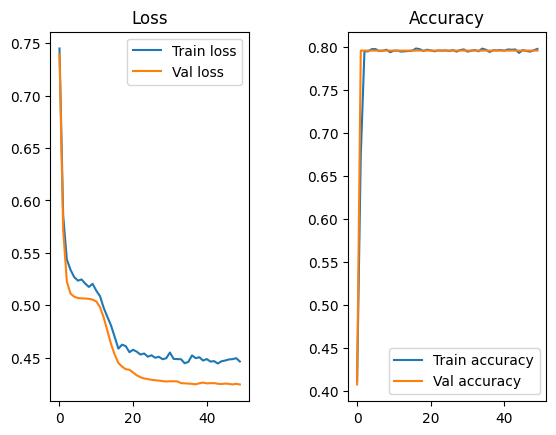

In [93]:
plt.subplots_adjust(wspace=0.5)
plt.subplot(1, 2, 1)
plt.plot(stats['loss_train'], label='Train loss')
plt.plot(stats['loss_val'], label='Val loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(stats['acc_train'], label='Train accuracy')
plt.plot(stats['acc_val'], label='Val accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

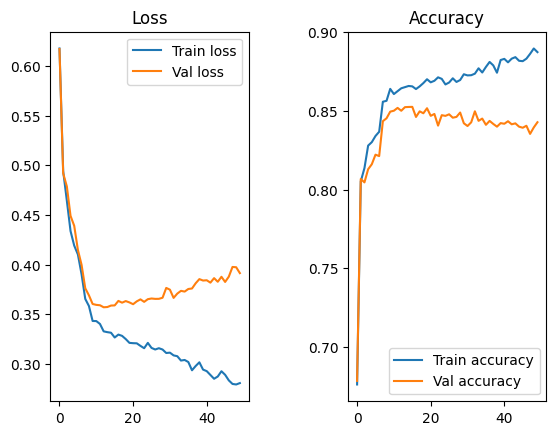

In [94]:
plt.subplots_adjust(wspace=0.5)
plt.subplot(1, 2, 1)
plt.plot(stats_2['loss_train'], label='Train loss')
plt.plot(stats_2['loss_val'], label='Val loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(stats_2['acc_train'], label='Train accuracy')
plt.plot(stats_2['acc_val'], label='Val accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

### Сравнение с готовыми решениями

In [95]:
with torch.no_grad():
  perc_pred = model_2(X_test)
perc_pred = np.where(perc_pred.numpy()>=0.5, 1, 0)

In [96]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Преобразование PyTorch данных в NumPy для использования в моделях sklearn
X_train_n = X_train.numpy()  # признаки тренировочного набора
Y_train_n = Y_train.numpy().ravel()  # метки тренировочного набора

X_test_n = X_test.numpy()    # признаки тестового набора
Y_test_n = Y_test.numpy().ravel()    # метки тестового набора

# Обучение и тестирование алгоритма LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train_n, Y_train_n)
log_reg_pred = log_reg.predict(X_test_n)
print("Classification Report for LogisticRegression")
print(classification_report(Y_test_n, log_reg_pred))

# Обучение и тестирование алгоритма KNN с параметрами по-умолчанию.
knn = KNeighborsClassifier()
knn.fit(X_train_n, Y_train_n)
knn_pred = knn.predict(X_test_n)
print("Classification Report for KNeighborsClassifier")
print(classification_report(Y_test_n, knn_pred))

# Обучение и тестирование алгоритма Random Forest с параметрами по-умолчанию.
random_forset = RandomForestClassifier()
random_forset.fit(X_train_n, Y_train_n)
random_forset_pred = random_forset.predict(X_test_n)
print("Classification Report for RandomForestClassifier")
print(classification_report(Y_test_n, random_forset_pred))

# # Тестирование Multilayer Perceptron
print("Classification Report for Our Multilayer Perceptron")
print(classification_report(Y_test_n, perc_pred))

Classification Report for LogisticRegression
              precision    recall  f1-score   support

         0.0       0.82      0.96      0.89       797
         1.0       0.56      0.20      0.29       203

    accuracy                           0.81      1000
   macro avg       0.69      0.58      0.59      1000
weighted avg       0.77      0.81      0.77      1000

Classification Report for KNeighborsClassifier
              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91       797
         1.0       0.67      0.43      0.52       203

    accuracy                           0.84      1000
   macro avg       0.77      0.69      0.71      1000
weighted avg       0.83      0.84      0.83      1000

Classification Report for RandomForestClassifier
              precision    recall  f1-score   support

         0.0       0.88      0.96      0.92       797
         1.0       0.78      0.50      0.61       203

    accuracy                           0.